In [2]:
import xarray as xr

ds = xr.open_dataset("Data/dt_global_allsat_phy_l4_20211209_20220422.nc")
display(ds)

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2021-12-09
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             int32 ...
    lat_bnds        (latitude, nv) float32 ...
    lon_bnds        (longitude, nv) float32 ...
    sla             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 ...
    adt             (time, latitude, longitude) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2021-12-09T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2021-12-08T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

#### Geostrophic Current
$$u_s = -\frac{g}{f}\frac{\partial{\eta}}{\partial{y}}$$
$$v_s = \frac{g}{f}\frac{\partial{\eta}}{\partial{x}}$$

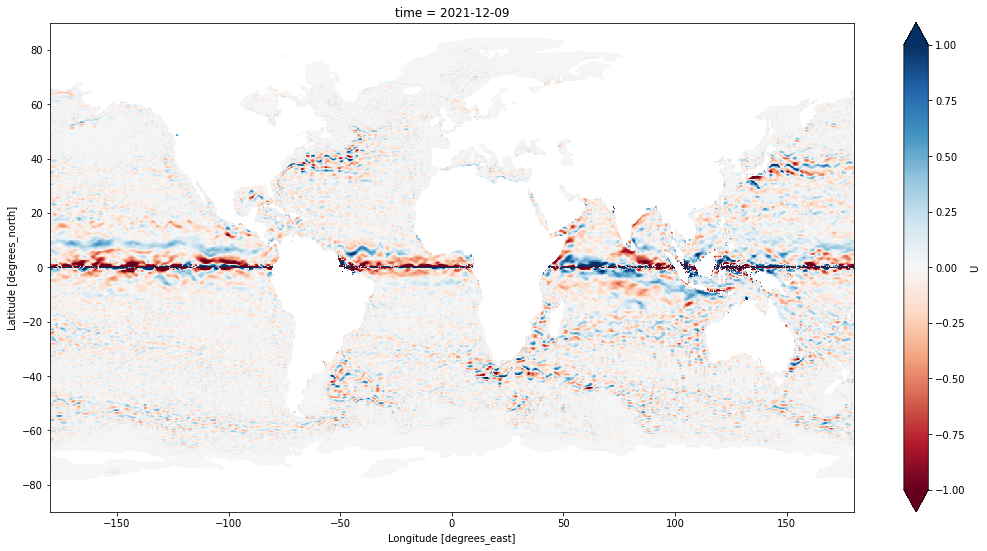

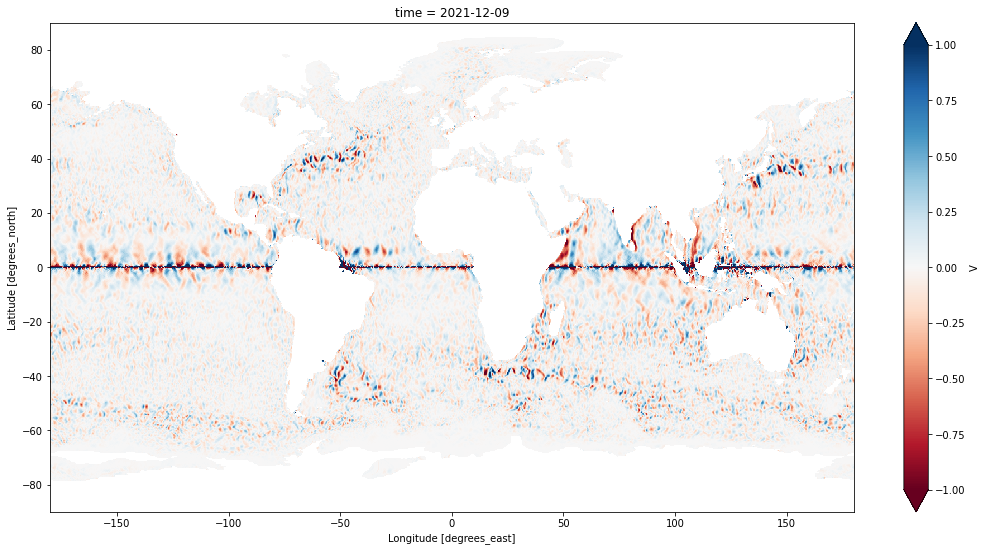

In [45]:
import numpy as np
import matplotlib.pyplot as plt

distance = 0.25*110e3

def geostream(ssh,lon,lat):
    R = 6300e3
    OMEGA = 7.292e-5
    g = 9.8
    dy = R*np.radians(0.25)
    dx = R*np.cos(np.radians(lat))*np.radians(0.25)
    lon, lat = np.meshgrid(lon, lat)
    f = 2*OMEGA*np.sin(np.radians(lat))
    u = -(g/f)*np.gradient(ssh,dy,axis=1)
    grad_x = np.empty_like(ssh)
    # dx vary along axis 1
    for i in range(len(dx)):
        grad_x[:, [i], :] = np.gradient(ssh[:, [i], :], dx.values[i], axis=2)
    v = g/f * grad_x
    return u,v

# lon, lat = ds.lon_bnds.mean(axis=1).values, ds.lat_bnds.mean(axis=1).values
u,v = geostream(ds['sla'],ds.longitude,ds.latitude)
u,v = geostream(ds['adt'],ds.longitude,ds.latitude)

ds["U"] = (('time', 'latitude', 'longitude'), u)
ds["V"] = (('time', 'latitude', 'longitude'), v)

fig = plt.figure(figsize=[18,9])
ax = fig.add_subplot(111)
ds.isel(time=0).U.plot.imshow(ax=ax, vmin=-1, vmax=1, cmap="RdBu")

fig = plt.figure(figsize=[18,9])
ax = fig.add_subplot(111)
ds.isel(time=0).V.plot.imshow(ax=ax, vmin=-1, vmax=1, cmap="RdBu")


#### Validate
- $u_{cal}-u_{real}$ should be 0
- $v_{cal}-v_{real}$ should be 0

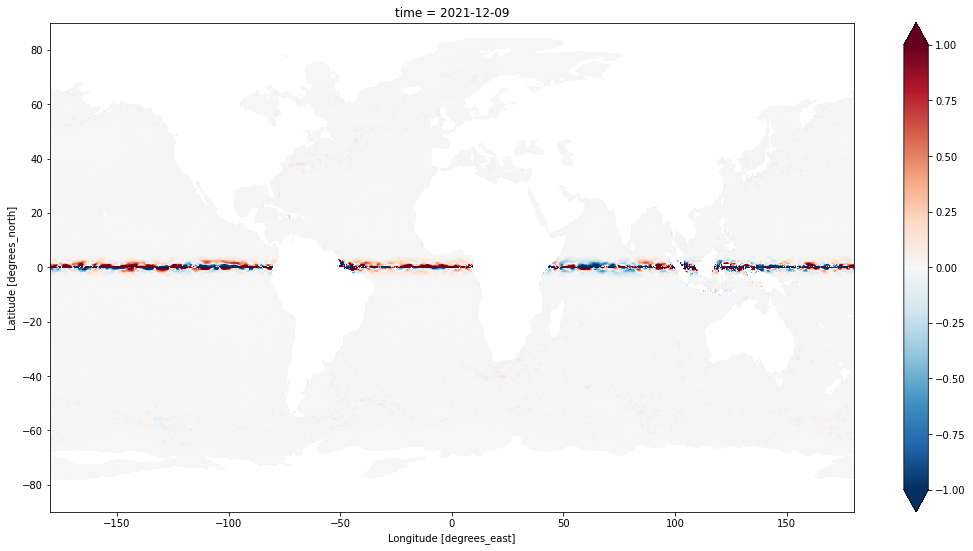

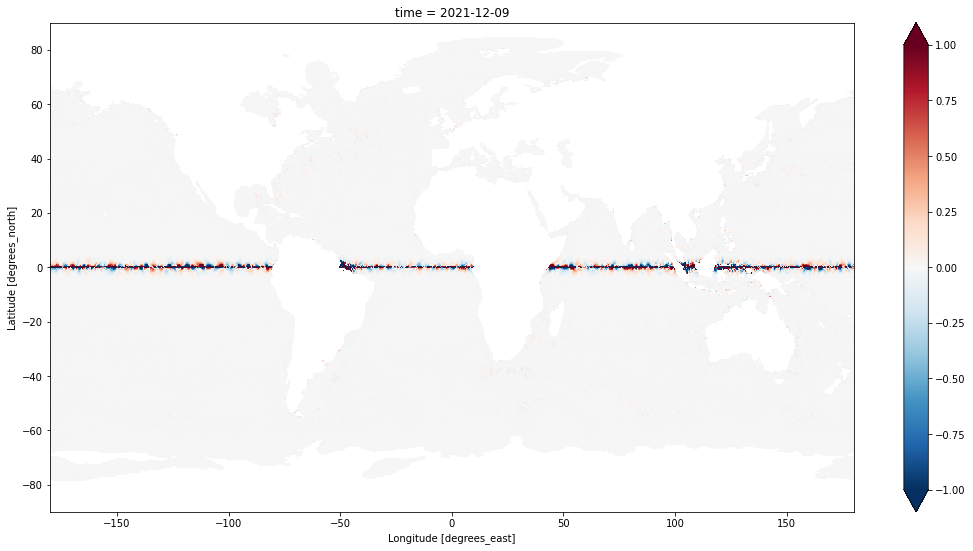

In [46]:
fig = plt.figure(figsize=[18,9])
ax = fig.add_subplot(111)
ua = (ds.ugosa-ds.U)
ua.isel(time=0).plot.imshow(ax=ax, vmin=-1, vmax=1, cmap="RdBu_r")
fig.savefig("ua.png")

fig = plt.figure(figsize=[18,9])
ax = fig.add_subplot(111)
va = (ds.vgosa-ds.V)
va.isel(time=0).plot.imshow(ax=ax, vmin=-1, vmax=1, cmap="RdBu_r")
fig.savefig("va.png")